In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import psutil
import os
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Function to log memory usage
def log_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

logger.info("Environment setup complete.")

2025-04-18 20:33:41,118 - INFO - Environment setup complete.


In [3]:
def load_mimic_data(chunk_size=100000):
    """Load MIMIC-III dataset in chunks to handle large files."""
    try:
        # Define dtypes to optimize memory
        chartevents_dtypes = {
            'SUBJECT_ID': 'Int32', 'HADM_ID': 'Int32', 'ITEMID': 'Int32',
            'CHARTTIME': 'object', 'VALUENUM': 'float32'
        }
        noteevents_dtypes = {
            'SUBJECT_ID': 'Int32', 'HADM_ID': 'Int32', 'TEXT': 'object'
        }
        diagnoses_dtypes = {
            'SUBJECT_ID': 'Int32', 'HADM_ID': 'Int32', 'ICD9_CODE': 'object'
        }
        patients_dtypes = {
            'SUBJECT_ID': 'Int32', 'GENDER': 'object', 'DOB': 'object'
        }

        # Load CHARTEVENTS
        logger.info("Loading CHARTEVENTS.csv...")
        chartevents_chunks = [
            chunk for chunk in pd.read_csv(
                "data/CHARTEVENTS.csv",
                usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM'],
                dtype=chartevents_dtypes,
                chunksize=chunk_size
            )
        ]
        chartevents = pd.concat(chartevents_chunks, axis=0)
        logger.info(f"CHARTEVENTS shape: {chartevents.shape}")
        log_memory_usage()

        # Load NOTEEVENTS
        logger.info("Loading NOTEEVENTS.csv...")
        noteevents_chunks = [
            chunk for chunk in pd.read_csv(
                "data/NOTEEVENTS.csv",
                usecols=['SUBJECT_ID', 'HADM_ID', 'TEXT'],
                dtype=noteevents_dtypes,
                chunksize=chunk_size
            )
        ]
        noteevents = pd.concat(noteevents_chunks, axis=0)
        logger.info(f"NOTEEVENTS shape: {noteevents.shape}")
        log_memory_usage()

        # Load DIAGNOSES_ICD
        logger.info("Loading DIAGNOSES_ICD.csv...")
        diagnoses_chunks = [
            chunk for chunk in pd.read_csv(
                "data/DIAGNOSES_ICD.csv",
                usecols=['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'],
                dtype=diagnoses_dtypes,
                chunksize=chunk_size
            )
        ]
        diagnoses = pd.concat(diagnoses_chunks, axis=0)
        logger.info(f"DIAGNOSES shape: {diagnoses.shape}")
        log_memory_usage()

        # Load PATIENTS
        logger.info("Loading PATIENTS.csv...")
        patients = pd.read_csv(
            "data/PATIENTS.csv",
            usecols=['SUBJECT_ID', 'GENDER', 'DOB'],
            dtype=patients_dtypes
        )
        logger.info(f"PATIENTS shape: {patients.shape}")
        log_memory_usage()

        return chartevents, noteevents, diagnoses, patients
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

# Execute data loading
chartevents, noteevents, diagnoses, patients = load_mimic_data()

2025-04-18 20:33:48,428 - INFO - Loading CHARTEVENTS.csv...
2025-04-18 20:41:26,154 - INFO - CHARTEVENTS shape: (330712483, 5)
2025-04-18 20:41:26,157 - INFO - Memory usage: 2877.84 MB
2025-04-18 20:41:26,157 - INFO - Loading NOTEEVENTS.csv...
2025-04-18 20:41:54,688 - INFO - NOTEEVENTS shape: (2083180, 3)
2025-04-18 20:41:54,691 - INFO - Memory usage: 4147.50 MB
2025-04-18 20:41:54,692 - INFO - Loading DIAGNOSES_ICD.csv...
2025-04-18 20:41:55,224 - INFO - DIAGNOSES shape: (651047, 3)
2025-04-18 20:41:55,224 - INFO - Memory usage: 4111.84 MB
2025-04-18 20:41:55,225 - INFO - Loading PATIENTS.csv...
2025-04-18 20:41:55,265 - INFO - PATIENTS shape: (46520, 3)
2025-04-18 20:41:55,266 - INFO - Memory usage: 4119.69 MB


In [4]:
def preprocess_vitals(chartevents, time_steps=12, chunk_size=50000):
    """Preprocess vital signs into hourly aggregated time-series."""
    try:
        # Vital signs to extract
        vital_ids = {220045: "heart_rate", 220181: "mean_bp", 220210: "resp_rate"}
        vitals_chunks = []

        logger.info("Filtering and pivoting vitals...")
        for start in tqdm(range(0, len(chartevents), chunk_size), desc="Processing vitals"):
            chunk = chartevents.iloc[start:start + chunk_size]
            vital_chunk = chunk[chunk["ITEMID"].isin(vital_ids.keys())][
                ["SUBJECT_ID", "HADM_ID", "CHARTTIME", "ITEMID", "VALUENUM"]
            ]
            if not vital_chunk.empty:
                pivoted = vital_chunk.pivot_table(
                    index=["SUBJECT_ID", "HADM_ID", "CHARTTIME"],
                    columns="ITEMID",
                    values="VALUENUM",
                    aggfunc='mean'
                ).reset_index()
                new_columns = ["SUBJECT_ID", "HADM_ID", "CHARTTIME"] + [
                    vital_ids.get(col, str(col)) for col in pivoted.columns[3:]
                ]
                pivoted.columns = new_columns
                for vital in ["heart_rate", "mean_bp", "resp_rate"]:
                    if vital not in pivoted.columns:
                        pivoted[vital] = pd.NA
                vitals_chunks.append(pivoted)
            log_memory_usage()

        vitals = pd.concat(vitals_chunks, axis=0)
        logger.info(f"Pivoted vitals shape: {vitals.shape}")
        vitals["CHARTTIME"] = pd.to_datetime(vitals["CHARTTIME"], errors='coerce')
        
        # Aggregate by hour
        logger.info("Grouping vitals by hour...")
        vitals = vitals.groupby(
            ["SUBJECT_ID", "HADM_ID", pd.Grouper(key="CHARTTIME", freq="H")]
        ).mean().reset_index()

        # Handle missing values
        logger.info("Filling missing values...")
        vitals = vitals.sort_values(['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'])
        vitals[['heart_rate', 'mean_bp', 'resp_rate']] = vitals.groupby(
            ['SUBJECT_ID', 'HADM_ID']
        )[['heart_rate', 'mean_bp', 'resp_rate']].ffill()
        for col in ['heart_rate', 'mean_bp', 'resp_rate']:
            vitals[col] = vitals[col].fillna(vitals[col].mean())
        logger.info(f"Processed vitals shape: {vitals.shape}")
        log_memory_usage()
        return vitals
    except Exception as e:
        logger.error(f"Error in preprocess_vitals: {e}")
        raise

# Preprocess vitals
vitals = preprocess_vitals(chartevents)

2025-04-18 20:42:26,391 - INFO - Filtering and pivoting vitals...
Processing vitals:   0%|          | 1/6615 [00:00<15:31,  7.10it/s]2025-04-18 20:42:26,829 - INFO - Memory usage: 6453.84 MB
2025-04-18 20:42:26,838 - INFO - Memory usage: 6455.94 MB
2025-04-18 20:42:26,848 - INFO - Memory usage: 6458.19 MB
2025-04-18 20:42:26,857 - INFO - Memory usage: 6460.23 MB
2025-04-18 20:42:26,866 - INFO - Memory usage: 6462.61 MB
2025-04-18 20:42:26,875 - INFO - Memory usage: 6465.86 MB
2025-04-18 20:42:26,922 - INFO - Memory usage: 6094.55 MB
Processing vitals:   0%|          | 8/6615 [00:00<02:52, 38.32it/s]2025-04-18 20:42:26,932 - INFO - Memory usage: 6097.23 MB
2025-04-18 20:42:26,941 - INFO - Memory usage: 6098.78 MB
2025-04-18 20:42:26,951 - INFO - Memory usage: 6100.17 MB
2025-04-18 20:42:26,983 - INFO - Memory usage: 5878.19 MB
2025-04-18 20:42:27,070 - INFO - Memory usage: 5096.47 MB
Processing vitals:   0%|          | 13/6615 [00:00<03:03, 35.98it/s]2025-04-18 20:42:27,092 - INFO - Mem

In [5]:
def extract_note_features(noteevents, simple=True, chunk_size=50000):
    """Extract binary features from clinical notes."""
    try:
        notes_chunks = []
        logger.info("Processing notes...")
        for start in tqdm(range(0, len(noteevents), chunk_size), desc="Processing notes"):
            chunk = noteevents.iloc[start:start + chunk_size][["SUBJECT_ID", "HADM_ID", "TEXT"]].dropna()
            if not chunk.empty:
                chunk["infection"] = chunk["TEXT"].str.contains(
                    "infection|sepsis", case=False, na=False
                ).astype('int8')
                chunk["fever"] = chunk["TEXT"].str.contains(
                    "fever|temp", case=False, na=False
                ).astype('int8')
                notes_chunks.append(chunk[["SUBJECT_ID", "HADM_ID", "infection", "fever"]])
            log_memory_usage()
        notes = pd.concat(notes_chunks, axis=0)
        result = notes.groupby(["SUBJECT_ID", "HADM_ID"])[["infection", "fever"]].max().reset_index()
        logger.info(f"Note features shape: {result.shape}")
        log_memory_usage()
        return result
    except Exception as e:
        logger.error(f"Error in extract_note_features: {e}")
        raise

# Extract note features
note_features = extract_note_features(noteevents)

2025-04-18 20:43:06,025 - INFO - Processing notes...
Processing notes: 100%|██████████| 42/42 [01:52<00:00,  2.68s/it]
2025-04-18 20:44:58,682 - INFO - Note features shape: (58361, 4)
2025-04-18 20:44:58,682 - INFO - Memory usage: 5685.42 MB


In [6]:
def get_sepsis_labels(diagnoses):
    """Identify sepsis cases based on ICD9 codes."""
    try:
        sepsis_codes = ["99591", "99592", "78552"]
        labels = diagnoses[diagnoses["ICD9_CODE"].isin(sepsis_codes)][
            ["SUBJECT_ID", "HADM_ID"]
        ].drop_duplicates()
        labels["sepsis"] = 1
        logger.info(f"Sepsis labels shape: {labels.shape}")
        log_memory_usage()
        return labels
    except Exception as e:
        logger.error(f"Error in get_sepsis_labels: {e}")
        raise

# Generate labels
labels = get_sepsis_labels(diagnoses)

2025-04-18 20:45:02,705 - INFO - Sepsis labels shape: (5325, 3)
2025-04-18 20:45:02,705 - INFO - Memory usage: 5398.00 MB


In [7]:
def prepare_data(vitals, note_features, labels, time_steps=12):
    """Prepare time-series data for modeling."""
    try:
        # Merge data
        data = vitals.merge(note_features, on=["SUBJECT_ID", "HADM_ID"], how="left")
        data = data.merge(labels, on=["SUBJECT_ID", "HADM_ID"], how="left").fillna({"sepsis": 0})
        data[['infection', 'fever']] = data[['infection', 'fever']].fillna(0)
        logger.info(f"Merged data shape: {data.shape}")
        log_memory_usage()

        # Create time-series windows
        X, y, subject_hadm = [], [], []
        feature_names = ["heart_rate", "mean_bp", "resp_rate", "infection", "fever"]
        for (subject_id, hadm_id), group in tqdm(
            data.groupby(["SUBJECT_ID", "HADM_ID"]), desc="Creating windows"
        ):
            group = group.sort_values("CHARTTIME")
            if len(group) >= time_steps:
                for i in range(len(group) - time_steps + 1):
                    window = group.iloc[i:i+time_steps][feature_names].values
                    if window.shape[0] == time_steps:
                        X.append(window)
                        y.append(group.iloc[i+time_steps-1]["sepsis"])
                        subject_hadm.append((subject_id, hadm_id))
            log_memory_usage()

        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.int8)
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")

        # Normalize vital signs
        X[:, :, :3] = (X[:, :, :3] - X[:, :, :3].mean(axis=(0, 1))) / (
            X[:, :, :3].std(axis=(0, 1)) + 1e-8
        )

        return X, y, feature_names, subject_hadm
    except Exception as e:
        logger.error(f"Error in prepare_data: {e}")
        raise

# Prepare data
X, y, feature_names, subject_hadm = prepare_data(vitals, note_features, labels)

2025-04-18 20:45:05,676 - INFO - Merged data shape: (1962600, 9)
2025-04-18 20:45:05,677 - INFO - Memory usage: 5018.98 MB
Creating windows:   0%|          | 1/21927 [00:00<54:37,  6.69it/s]2025-04-18 20:45:06,361 - INFO - Memory usage: 4665.86 MB
2025-04-18 20:45:06,382 - INFO - Memory usage: 4665.91 MB
2025-04-18 20:45:06,389 - INFO - Memory usage: 4665.92 MB
2025-04-18 20:45:06,397 - INFO - Memory usage: 4665.92 MB
2025-04-18 20:45:06,402 - INFO - Memory usage: 4665.97 MB
2025-04-18 20:45:06,419 - INFO - Memory usage: 4666.02 MB
2025-04-18 20:45:06,424 - INFO - Memory usage: 4666.03 MB
2025-04-18 20:45:06,425 - INFO - Memory usage: 4666.03 MB
2025-04-18 20:45:06,442 - INFO - Memory usage: 4666.06 MB
2025-04-18 20:45:06,446 - INFO - Memory usage: 4666.08 MB
2025-04-18 20:45:06,498 - INFO - Memory usage: 4666.16 MB
Creating windows:   0%|          | 12/21927 [00:00<07:44, 47.17it/s]2025-04-18 20:45:06,501 - INFO - Memory usage: 4666.16 MB
2025-04-18 20:45:06,506 - INFO - Memory usage:

In [8]:
# Split data
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, range(len(y)), test_size=0.2, random_state=42
)
logger.info("Data splitting completed.")

# Logistic Regression
logger.info("Training logistic regression...")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)
lr_pred = lr_model.predict_proba(X_test_flat)[:, 1]
lr_auroc = roc_auc_score(y_test, lr_pred)
logger.info(f"Logistic Regression AUROC: {lr_auroc:.3f}")
log_memory_usage()

# LSTM Model
logger.info("Training LSTM model...")
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)
logger.info("LSTM training completed.")
log_memory_usage()

# Evaluate LSTM
y_pred = lstm_model.predict(X_test).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)
auroc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred_binary, zero_division=0)
recall = recall_score(y_test, y_pred_binary, zero_division=0)
f1 = f1_score(y_test, y_pred_binary, zero_division=0)
logger.info(f"LSTM AUROC: {auroc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
log_memory_usage()

2025-04-18 20:51:23,225 - INFO - Data splitting completed.
2025-04-18 20:51:23,225 - INFO - Training logistic regression...
2025-04-18 20:51:33,535 - INFO - Logistic Regression AUROC: 0.722
2025-04-18 20:51:33,537 - INFO - Memory usage: 2083.91 MB
2025-04-18 20:51:33,562 - INFO - Training LSTM model...
/Users/jesusminjares/Desktop/UT Austin MSAI/Courses/ AI395T AI in Healthcare/ai_healthcare/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
34467/34467 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.7459 - loss: 0.5080 - val_accuracy: 0.7490 - val_loss: 0.5022
Epoch 2/5
34467/34467 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - accuracy: 0.7500 - loss: 0.5016 - val_accuracy: 0.7491 - val_loss: 0.5018
Epoch 3/5
34467/34467 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.7500 - loss: 0.5011 - val_accuracy: 0.7495 - val_loss: 0.4999
Epoch 4/5
34467/34467 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - accuracy: 0.7513 - loss: 0.4996 - val_accuracy: 0.7494 - val_loss: 0.4999
Epoch 5/5
34467/34467 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.7506 - loss: 0.4989 - val_accuracy: 0.7506 - val_loss: 0.4984


2025-04-18 20:59:32,681 - INFO - LSTM training completed.
2025-04-18 20:59:32,682 - INFO - Memory usage: 645.92 MB


10771/10771 ━━━━━━━━━━━━━━━━━━━━ 9s 789us/step


2025-04-18 20:59:43,006 - INFO - LSTM AUROC: 0.737, Precision: 0.571, Recall: 0.183, F1: 0.277
2025-04-18 20:59:43,006 - INFO - Memory usage: 1003.22 MB


In [9]:
# Process demographic data
demo_data = patients[["SUBJECT_ID", "GENDER", "DOB"]].copy()
demo_data["DOB"] = demo_data["DOB"].fillna(pd.Timestamp('1900-01-01'))
demo_data["age"] = (pd.to_datetime("2025-04-18") - pd.to_datetime(demo_data["DOB"])).dt.days // 365
test_subjects = [subject_hadm[i][0] for i in test_idx]
demo_test = demo_data[demo_data["SUBJECT_ID"].isin(test_subjects)][["SUBJECT_ID", "GENDER", "age"]]

# Merge predictions
test_mapping = pd.DataFrame({
    'index': test_idx,
    'SUBJECT_ID': [subject_hadm[i][0] for i in test_idx],
    'y_true': y_test,
    'y_pred': y_pred,
    'y_pred_binary': y_pred_binary
})
demo_test = demo_test.merge(test_mapping[['SUBJECT_ID', 'y_true', 'y_pred', 'y_pred_binary']], 
                           on='SUBJECT_ID', how='left')
logger.info(f"Demo test shape: {demo_test.shape}")

# Fairness metrics by gender
fairness_metrics = demo_test.groupby("GENDER").apply(
    lambda x: pd.Series({
        "AUROC": roc_auc_score(x["y_true"], x["y_pred"]) if len(np.unique(x["y_true"])) > 1 else 0,
        "Precision": precision_score(x["y_true"], x["y_pred_binary"], zero_division=0),
        "Recall": recall_score(x["y_true"], x["y_pred_binary"], zero_division=0),
        "F1": f1_score(x["y_true"], x["y_pred_binary"], zero_division=0)
    })
).fillna(0)
logger.info("\nFairness Metrics by Gender:")
logger.info(fairness_metrics)
log_memory_usage()

2025-04-18 20:59:47,787 - INFO - Demo test shape: (344666, 6)
/var/folders/29/8ncbdz4n013f2p__f12f36qr0000gn/T/ipykernel_31854/2428265536.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fairness_metrics = demo_test.groupby("GENDER").apply(
2025-04-18 20:59:48,018 - INFO - 
Fairness Metrics by Gender:
2025-04-18 20:59:48,018 - INFO -            AUROC  Precision    Recall        F1
GENDER                                         
F       0.731026   0.535903  0.197372  0.288492
M       0.743124   0.601644  0.172464  0.268081
2025-04-18 20:59:48,023 - INFO - Memory usage: 1053.78 MB


2025-04-18 22:11:27,626 - INFO - Preparing data for SHAP analysis...
2025-04-18 22:11:27,712 - INFO - Computing SHAP values for 20 test samples...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-04-18 22:11:27,758 - INFO - num_full_subsets = 1
2025-04-18 22:11:27,759 - INFO - remaining_weight_vector = array([0.14057046, 0.09535774, 0.07279542, 0.05929518, 0.0503277 ,
       0.04395195, 0.03919753, 0.03552543, 0.03261235, 0.03025264,
       0.02830933, 0.02668768, 0.02532015, 0.02415729, 0.02316218,
       0.02230667, 0.02156901, 0.02093219, 0.02038272, 0.01990986,
       0.01950499, 0.01916119, 0.01887289, 0.01863563, 0.0184459 ,
       0.01830098, 0.01819885, 0.01813812, 0.01811797])
2025-04-18 22:11:27,759 - INFO - num_paired_subset_sizes = 29
2025-04-18 22:11:27,777 - INFO - weight_left = 0.7819204976079971
2025-04-18 22:11:30,918 - INFO - np.sum(w_aug) = 60.000000000000014
2025-04-18 22:11:30,919 - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
2025-04-18 22:11:30,930 - INFO - phi = array([0.        , 0.0332427 , 0.        , 0.        , 0.        ,
       0.        , 0.02731296, 0.        , 0.        , 0.        ,
       0.        , 0.02550991, 0.        , 0. 

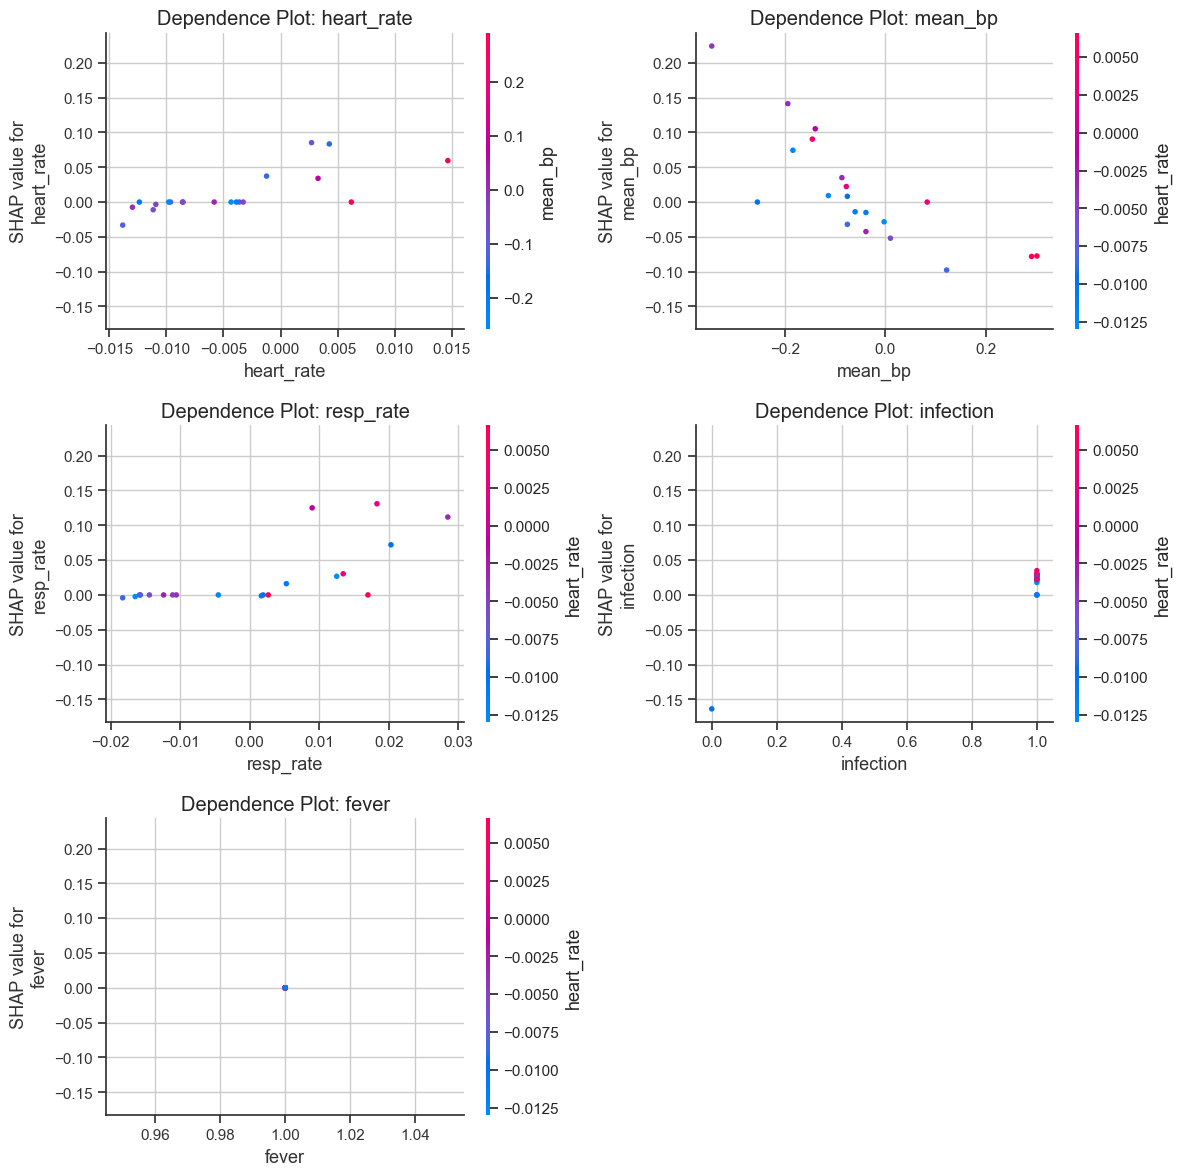

2025-04-18 22:12:31,677 - INFO - Combined SHAP dependence plots saved as figures/shap_dependence_combined.png
2025-04-18 22:12:31,677 - INFO - Memory usage: 1275.64 MB


In [73]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    # Define prediction function for SHAP
    def model_predict(data):
        data = data.reshape(-1, X_train.shape[1], X_train.shape[2])
        return lstm_model.predict(data, verbose=0).flatten()

    # Prepare data for SHAP
    logger.info("Preparing data for SHAP analysis...")
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    explainer = shap.KernelExplainer(model_predict, X_train_2d[:50])  # Background set
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    # Increase test samples for better SHAP computation, if memory allows
    n_samples = min(20, X_test_2d.shape[0])  # Use 20 samples or less
    logger.info(f"Computing SHAP values for {n_samples} test samples...")
    shap_values = explainer.shap_values(X_test_2d[:n_samples])
    
    # Original feature names with time steps (e.g., heart_rate_t0, heart_rate_t1, ...)
    shap_feature_names = [f"{f}_t{t}" for t in range(X.shape[1]) for f in feature_names]
    logger.info(f"Original SHAP values shape: {np.array(shap_values).shape}")
    
    # Aggregate SHAP values and feature values across time steps for each feature
    logger.info("Aggregating SHAP values and feature values across time steps...")
    n_features_per_timestep = len(feature_names)  # e.g., 5 features (heart_rate, mean_bp, resp_rate, infection, fever)
    n_timesteps = X.shape[1]  # e.g., 12 time steps
    shap_values_aggregated = np.zeros((n_samples, n_features_per_timestep))
    X_test_aggregated = np.zeros((n_samples, n_features_per_timestep))
    
    for i in range(n_features_per_timestep):
        # Sum SHAP values for feature i across all time steps
        feature_indices = list(range(i, n_timesteps * n_features_per_timestep, n_features_per_timestep))
        shap_values_aggregated[:, i] = np.sum(np.array(shap_values)[:, feature_indices], axis=1)
        # Average feature values across time steps
        X_test_aggregated[:, i] = np.mean(X_test_2d[:n_samples, feature_indices], axis=1)
    
    # Aggregated feature names (without time steps)
    aggregated_feature_names = feature_names  # e.g., ['heart_rate', 'mean_bp', 'resp_rate', 'infection', 'fever']
    
    # Debug: Check aggregated data
    logger.info(f"Aggregated SHAP values shape: {shap_values_aggregated.shape}")
    logger.info(f"Aggregated SHAP values (first sample): {shap_values_aggregated[0]}")
    logger.info(f"Aggregated feature data shape: {X_test_aggregated.shape}")
    logger.info(f"Aggregated feature data (first sample): {X_test_aggregated[0]}")
    if np.all(shap_values_aggregated == 0):
        logger.warning("All aggregated SHAP values are zero, which may result in an empty plot.")
    if np.any(np.isnan(shap_values_aggregated)):
        logger.warning("Aggregated SHAP values contain NaNs, which may result in an empty plot.")
    
    # Ensure figures directory exists
    os.makedirs('figures', exist_ok=True)

    # Generate a single figure with subplots for all SHAP dependence plots using axes
    logger.info("Generating combined SHAP dependence plots...")
    n_features = len(aggregated_feature_names)
    n_cols = 2  # Number of columns in the subplot grid
    n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharey=True)
    
    # Flatten axes for easier indexing if n_rows > 1, otherwise make it a list
    if n_rows == 1:
        axes = np.array([axes]) if n_cols == 1 else np.array(axes)
    else:
        axes = axes.flatten()

    for i, feature in enumerate(aggregated_feature_names):
        shap.dependence_plot(
            ind=i,
            shap_values=shap_values_aggregated,
            features=X_test_aggregated,
            feature_names=aggregated_feature_names,
            ax=axes[i],
            show=False  # We'll handle display and saving manually
        )
        axes[i].set_title(f'Dependence Plot: {feature}')
    
    # Hide any unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig('figures/shap_dependence_combined.png')
    plt.show()  # Display the plot in the notebook
    logger.info("Combined SHAP dependence plots saved as figures/shap_dependence_combined.png")

    log_memory_usage()
except Exception as e:
    logger.error(f"Error in SHAP visualization: {e}")
    raise

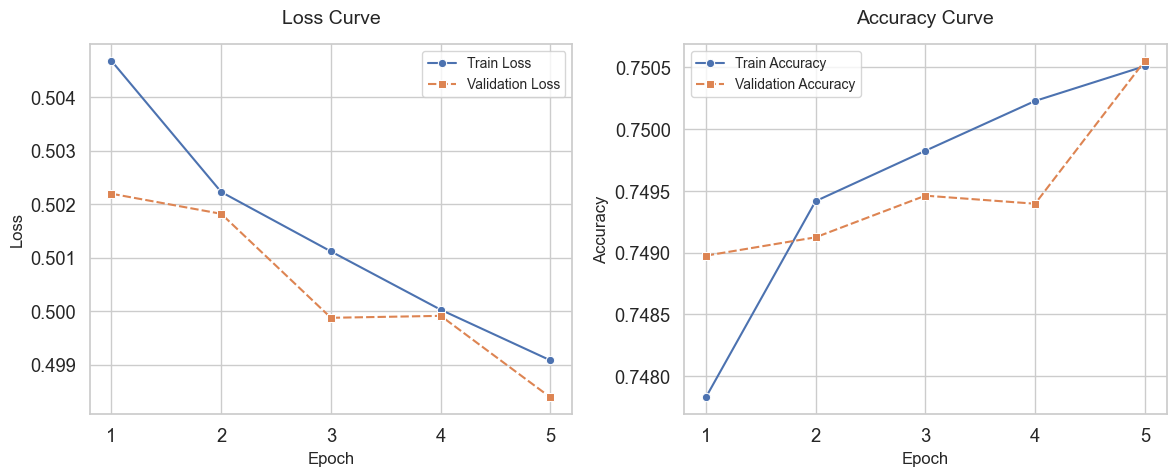

2025-04-18 22:12:37,194 - INFO - Training history plot saved as figures/training_history.png
2025-04-18 22:12:37,194 - INFO - Memory usage: 1318.30 MB


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Prepare data for Seaborn
epochs = range(1, len(history.history['loss']) + 1)
data = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs) + list(epochs) + list(epochs),
    'Value': history.history['loss'] + history.history['val_loss'] + history.history['accuracy'] + history.history['val_accuracy'],
    'Metric': ['Train Loss'] * len(epochs) + ['Validation Loss'] * len(epochs) + ['Train Accuracy'] * len(epochs) + ['Validation Accuracy'] * len(epochs)
})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot loss curves using Seaborn
sns.lineplot(data=data[data['Metric'].isin(['Train Loss', 'Validation Loss'])], 
             x='Epoch', y='Value', hue='Metric', style='Metric', 
             markers=['o', 's'], palette='deep', ax=ax1)
ax1.set_title('Loss Curve', fontsize=14, pad=15)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(title='', fontsize=10)

# Plot accuracy curves using Seaborn
sns.lineplot(data=data[data['Metric'].isin(['Train Accuracy', 'Validation Accuracy'])], 
             x='Epoch', y='Value', hue='Metric', style='Metric', 
             markers=['o', 's'], palette='deep', ax=ax2)
ax2.set_title('Accuracy Curve', fontsize=14, pad=15)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(title='', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig('figures/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("Training history plot saved as figures/training_history.png")

log_memory_usage()

In [75]:
def demo_biobert(noteevents, max_notes=50):  # Increased from 10 to 50
    """Extract BioBERT embeddings for a small subset of notes."""
    try:
        tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        sample_notes = noteevents["TEXT"].dropna().head(max_notes).tolist()
        embeddings = []
        for note in tqdm(sample_notes, desc="Processing BioBERT"):
            inputs = tokenizer(note, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings.append(embedding)
        embeddings = np.vstack(embeddings)
        logger.info(f"BioBERT Embeddings Shape: {embeddings.shape}")
        log_memory_usage()
        return embeddings
    except Exception as e:
        logger.error(f"Error in demo_biobert: {e}")
        raise

# Run BioBERT demo
biobert_embeddings = demo_biobert(noteevents, max_notes=50)

Processing BioBERT: 100%|██████████| 50/50 [00:06<00:00,  8.25it/s]
2025-04-18 22:12:48,666 - INFO - BioBERT Embeddings Shape: (50, 768)
2025-04-18 22:12:48,667 - INFO - Memory usage: 5325.55 MB


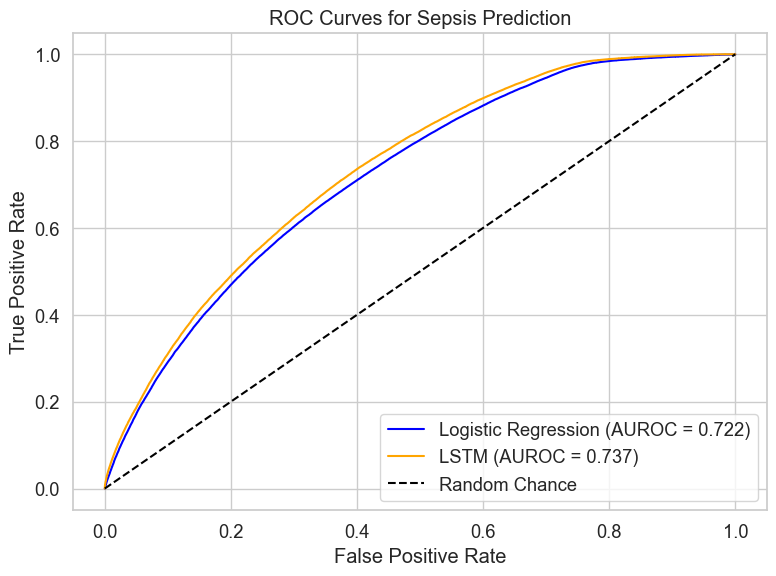

2025-04-18 22:12:53,199 - INFO - ROC curves plot saved as roc_curves.png


In [76]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUROC = {lr_auroc:.3f})', color='blue')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUROC = {auroc:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sepsis Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/roc_curves.png')
plt.show()
logger.info("ROC curves plot saved as roc_curves.png")

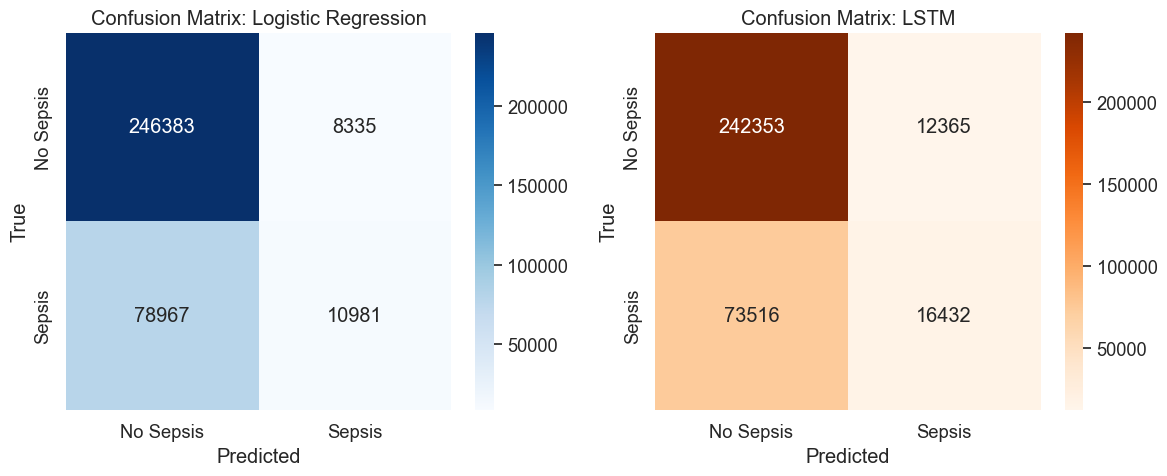

2025-04-18 22:12:56,057 - INFO - Confusion matrices plot saved as confusion_matrices.png


In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrices
lr_pred_binary = (lr_pred > 0.5).astype(int)
lr_cm = confusion_matrix(y_test, lr_pred_binary)
lstm_cm = confusion_matrix(y_test, y_pred_binary)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
axes[0].set_title('Confusion Matrix: Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
axes[1].set_title('Confusion Matrix: LSTM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('figures/confusion_matrices.png')
plt.show()
logger.info("Confusion matrices plot saved as confusion_matrices.png")

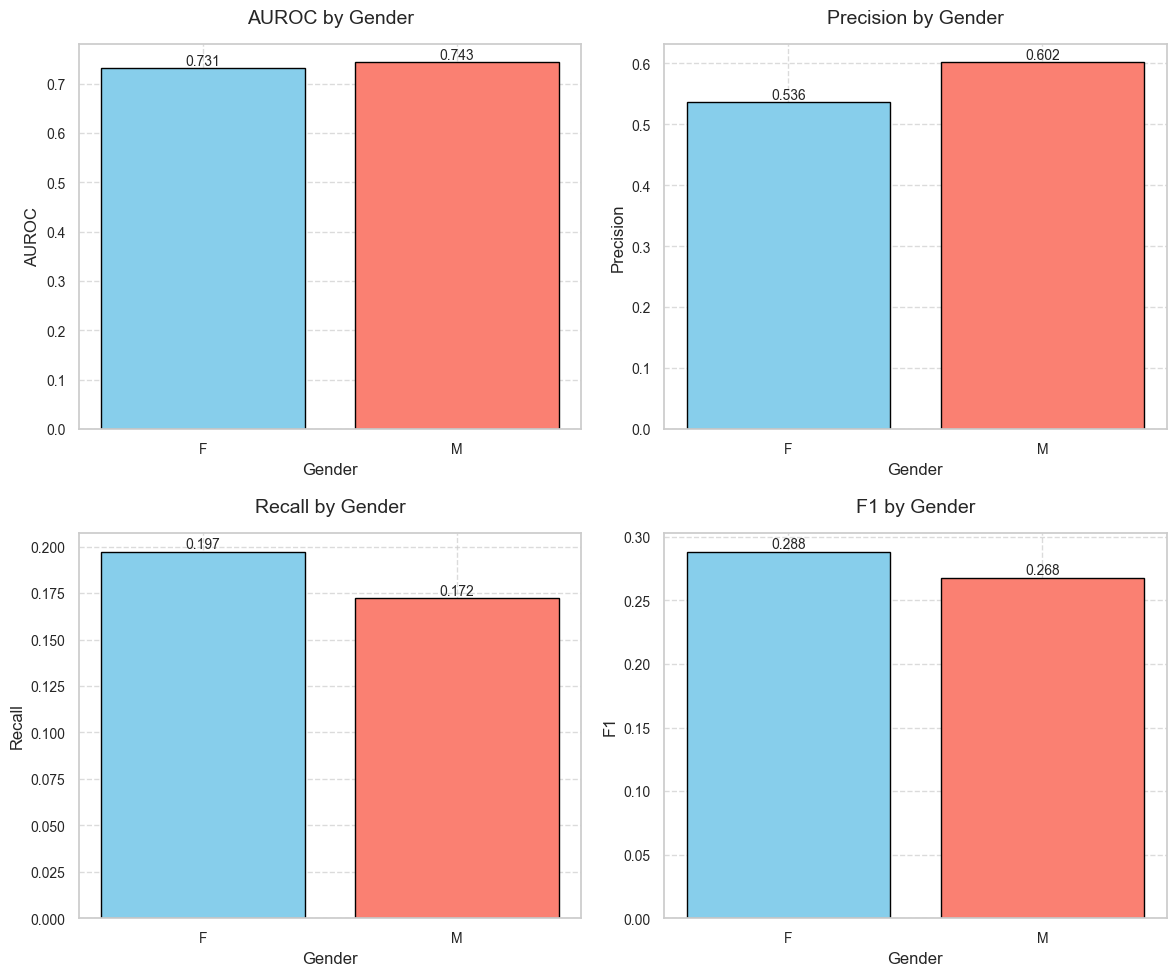

2025-04-18 22:12:59,690 - INFO - Fairness metrics plot saved as figures/fairness_metrics.png


In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare fairness metrics for plotting
# Check if fairness_metrics already has GENDER as a column
if 'GENDER' in fairness_metrics.columns:
    # If GENDER is already a column, no need to reset_index again
    pass
else:
    # If GENDER is the index, reset it, dropping any existing level_0 or index columns
    if 'level_0' in fairness_metrics.columns:
        fairness_metrics = fairness_metrics.drop(columns='level_0')
    if 'index' in fairness_metrics.columns:
        fairness_metrics = fairness_metrics.drop(columns='index')
    fairness_metrics = fairness_metrics.reset_index()

metrics = ['AUROC', 'Precision', 'Recall', 'F1']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each metric using Matplotlib bar plot
for i, metric in enumerate(metrics):
    ax = axes[i]
    # Prepare data for bar plot
    genders = fairness_metrics['GENDER']
    values = fairness_metrics[metric]
    
    # Plot bars
    bars = ax.bar(genders, values, color=['skyblue', 'salmon'], edgecolor='black')
    
    # Add annotations on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', (bar.get_x() + bar.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)
    
    # Customize labels and title
    ax.set_title(f'{metric} by Gender', fontsize=14, pad=15)
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.savefig('figures/fairness_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("Fairness metrics plot saved as figures/fairness_metrics.png")

2025-04-18 22:13:04,615 - INFO - Number of BioBERT embeddings to plot: 50
2025-04-18 22:13:04,616 - INFO - Visualizing BioBERT embeddings with t-SNE...


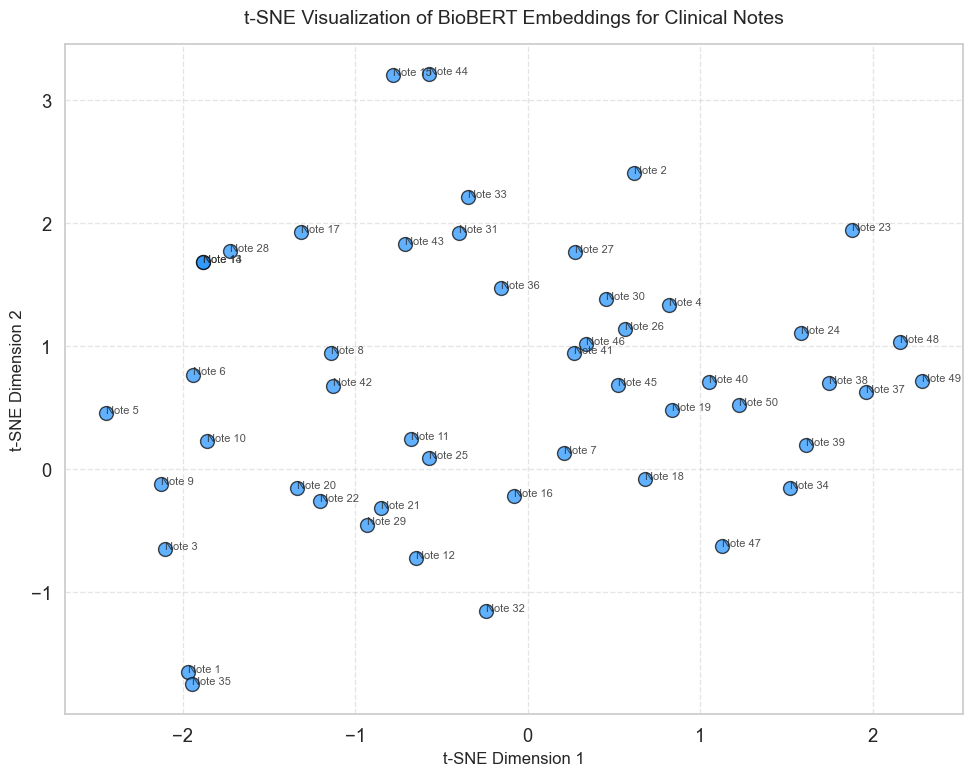

2025-04-18 22:13:05,531 - INFO - BioBERT embeddings t-SNE plot saved as figures/biobert_tsne_embeddings.png
2025-04-18 22:13:05,531 - INFO - Memory usage: 4848.16 MB


In [79]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

try:
    # Check number of samples
    n_samples = biobert_embeddings.shape[0]
    logger.info(f"Number of BioBERT embeddings to plot: {n_samples}")

    # Visualize embeddings with t-SNE
    logger.info("Visualizing BioBERT embeddings with t-SNE...")
    # Set perplexity to min(n_samples - 1, 30) to avoid ValueError (perplexity must be less than n_samples)
    perplexity = min(n_samples - 1, 30)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_embeddings = tsne.fit_transform(biobert_embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c='dodgerblue', s=100, alpha=0.7, edgecolors='black')
    for i in range(len(tsne_embeddings)):
        plt.annotate(f"Note {i+1}", (tsne_embeddings[i, 0], tsne_embeddings[i, 1]), fontsize=8, alpha=0.8)
    plt.title('t-SNE Visualization of BioBERT Embeddings for Clinical Notes', fontsize=14, pad=15)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('figures/biobert_tsne_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
    logger.info("BioBERT embeddings t-SNE plot saved as figures/biobert_tsne_embeddings.png")

    log_memory_usage()
except Exception as e:
    logger.error(f"Error in visualizing BioBERT embeddings: {e}")
    raise

2025-04-18 22:13:08,030 - INFO - Merging vitals with labels...
2025-04-18 22:13:08,170 - INFO - Data with labels shape: (1962600, 7)
2025-04-18 22:13:08,170 - INFO - Sampling 10000 rows for plotting...
2025-04-18 22:13:08,198 - INFO - Filtering extreme values...
2025-04-18 22:13:08,202 - INFO - Sampled data shape after filtering: (9466, 7)
2025-04-18 22:13:08,212 - INFO - Plotting histogram for heart_rate...
2025-04-18 22:13:08,253 - INFO - Plotting histogram for mean_bp...
2025-04-18 22:13:08,292 - INFO - Plotting histogram for resp_rate...


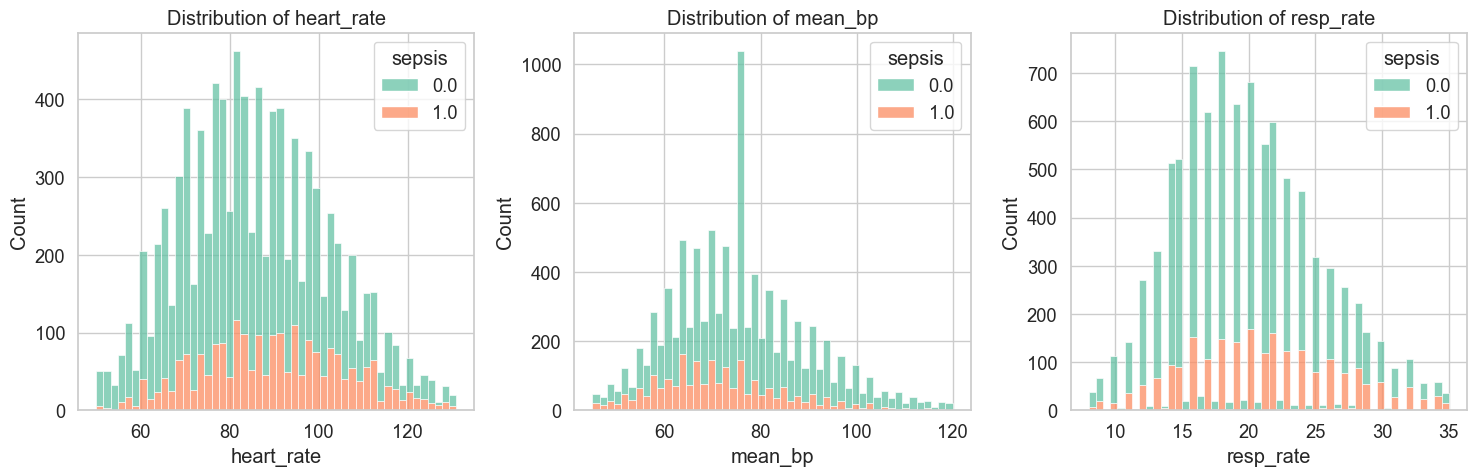

2025-04-18 22:13:08,690 - INFO - Feature distributions plot saved as figures/feature_distributions.png


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

try:
    # Merge vitals with labels
    logger.info("Merging vitals with labels...")
    data_with_labels = vitals.merge(labels, on=['SUBJECT_ID', 'HADM_ID'], how='left').fillna({'sepsis': 0})
    logger.info(f"Data with labels shape: {data_with_labels.shape}")

    # Sample data to reduce computation
    sample_size = min(10000, len(data_with_labels))  # Use 10,000 rows or less
    logger.info(f"Sampling {sample_size} rows for plotting...")
    data_sample = data_with_labels.sample(n=sample_size, random_state=42)

    # Filter extreme values
    logger.info("Filtering extreme values...")
    for feature in ['heart_rate', 'mean_bp', 'resp_rate']:
        data_sample = data_sample[
            (data_sample[feature].notna()) &
            (data_sample[feature] >= data_sample[feature].quantile(0.01)) &
            (data_sample[feature] <= data_sample[feature].quantile(0.99))
        ]

    logger.info(f"Sampled data shape after filtering: {data_sample.shape}")

    # Plot distributions
    features = ['heart_rate', 'mean_bp', 'resp_rate']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, feature in enumerate(features):
        logger.info(f"Plotting histogram for {feature}...")
        sns.histplot(
            data=data_sample,
            x=feature,
            hue='sepsis',
            multiple='stack',
            ax=axes[i],
            palette='Set2',
            bins=50
        )
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')

    plt.tight_layout()
    plt.savefig('figures/feature_distributions.png')
    plt.show()
    logger.info("Feature distributions plot saved as figures/feature_distributions.png")
except Exception as e:
    logger.error(f"Error in feature distributions plot: {e}")
    raise

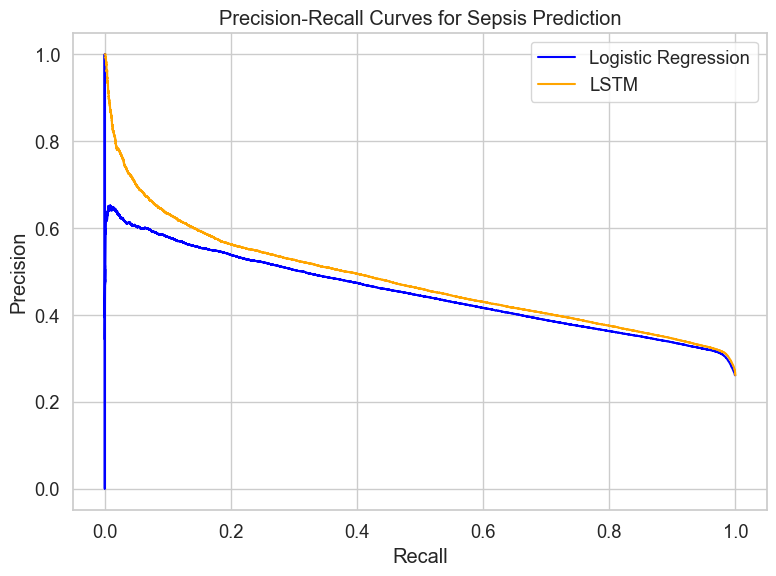

2025-04-18 22:13:11,615 - INFO - Precision-recall curves plot saved as precision_recall_curves.png


In [81]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curves
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_pred)
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lr_recall, lr_precision, label='Logistic Regression', color='blue')
plt.plot(lstm_recall, lstm_precision, label='LSTM', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Sepsis Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/precision_recall_curves.png')
plt.show()
logger.info("Precision-recall curves plot saved as precision_recall_curves.png")

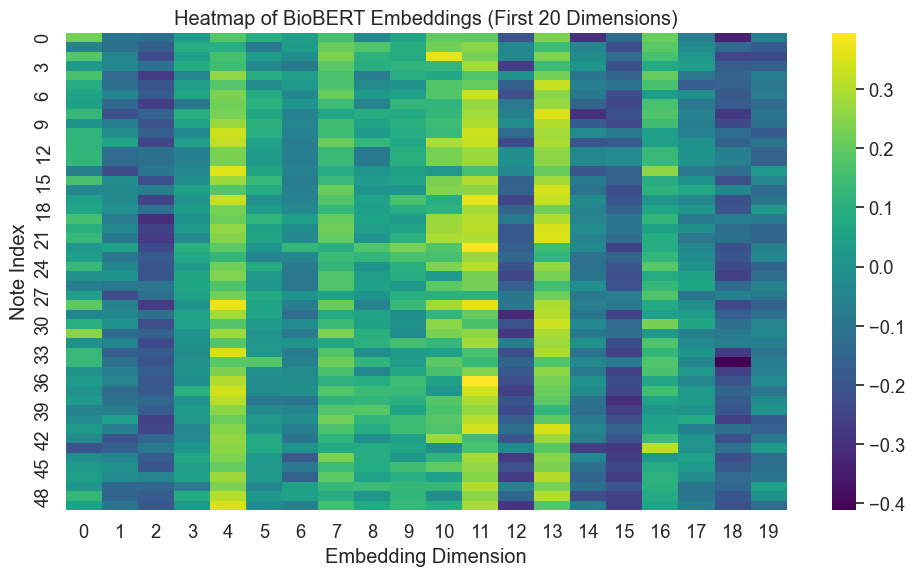

2025-04-18 22:13:14,053 - INFO - BioBERT embeddings heatmap saved as biobert_heatmap.png


In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of dimensions for visualization (e.g., first 20)
subset_embeddings = biobert_embeddings[:, :20]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(subset_embeddings, cmap='viridis', cbar=True)
plt.title('Heatmap of BioBERT Embeddings (First 20 Dimensions)')
plt.xlabel('Embedding Dimension')
plt.ylabel('Note Index')
plt.tight_layout()
plt.savefig('figures/biobert_heatmap.png')
plt.show()
logger.info("BioBERT embeddings heatmap saved as biobert_heatmap.png")